In [5]:
import pandas as pd
import bioframe as bf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import bbi
from gtfparse import read_gtf

# Looking into relationship with distal enhancers

### Gathering references

In [6]:
# TSS annotations
# deseq2 results

In [7]:
# importing reference tables and data outputs for the RNA-seq analysis

# outputs from basic-sleuth-mm9 mapping
deseq_results_folder = "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/deseq-mm9-results/"

# sample 2 conditions extracted from this project metadata
s2c = pd.read_csv("/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/supplementary/s2c.csv", index_col = 0)

# t2g to compare gene-level analysis
t2g = pd.read_csv("/project/fudenber_735/genomes/mm9/ensembl/ensembl_relational_downloads/biomaRt_mm9_t2g.csv", index_col = 0)

# DE results reported by paper (FPKM)
fpkm = pd.read_csv("/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/supplementary/supplement-10_RNA_seq_FPKM.csv", index_col=0)

In [8]:
# Gene annotations, references

# Reading gtf file that contains only the parsed TSSes
tss_df = read_gtf('/project/fudenber_735/genomes/mm9/ensembl/tsses.gtf')
# enhancer coordinates from elphege
enhancer_coords = bf.read_table('/project/fudenber_735/collaborations/karissa_2022/features/mm9/mESC_Enhancer_prediction_Chen12_BMCgenomics_mm9.bed',
                               schema='bedGraph',
                               skiprows=1)

# cleaning out less-well defined chromosome numbers
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('NT_'))]
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('MT'))]

# paste 'chr' to all chromosome names
tss_df["seqname"] = 'chr' + tss_df["seqname"]

# rename column to chrom to match bedframe/bioframe format
tss_df = tss_df.rename(columns= {"seqname" : "chrom"})

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['transcript_id', 'gene_id']


In [9]:
tss_df

,chrom,source,feature,start,end,score,strand,frame,transcript_id,gene_id
0,chr3,gffutils_derived,transcript,107949065,107949065,NaN,-,0,ENSMUST00000000001,ENSMUSG00000000001
1,chrX,gffutils_derived,transcript,75098963,75098963,NaN,-,0,ENSMUST00000000003,ENSMUSG00000000003
2,chrX,gffutils_derived,transcript,75098870,75098870,NaN,-,0,ENSMUST00000114041,ENSMUSG00000000003
3,chr16,gffutils_derived,transcript,18812066,18812066,NaN,-,0,ENSMUST00000000028,ENSMUSG00000000028
4,chr16,gffutils_derived,transcript,18811720,18811720,NaN,-,0,ENSMUST00000096990,ENSMUSG00000000028
...,...,...,...,...,...,...,...,...,...,...
95878,chr10,gffutils_derived,transcript,62020939,62020939,NaN,+,0,ENSMUST00000175629,ENSMUSG00000093370
95879,chr10,gffutils_derived,transcript,79964657,79964657,NaN,-,0,ENSMUST00000175630,ENSMUSG00000093371
95880,chr8,gffutils_derived,transcript,126139118,126139118,NaN,-,0,ENSMUST00000175631,ENSMUSG00000093372
95881,chr19,gffutils_derived,transcript,35351013,35351013,NaN,-,0,ENSMUST00000175632,ENSMUSG00000093373


## Variation 1: dCTCF DEGs mapped to mm9 (kallisto, DESeq)

- [x] download enhancer coords
- [x] apply TSS annotation to everything
- [x] separate DEGs by up, down, or unchanged
- [x] get all distances from tss to enhancers (bioframe func -- should be baby)
- [x] sort by distances
- [x] plottttyyyyy

In [10]:
# looks to be the right format
bf.SCHEMAS['bedGraph']

['chrom', 'start', 'end', 'value']

In [11]:
enhancer_coords

,chrom,start,end,value
0,chr3,34660001,34661000,1
1,chr7,3206001,3207000,1
2,chr8,91527001,91528000,1
3,chr9,110850001,110851000,1
4,chr12,87842001,87843000,"0,9999"
...,...,...,...,...
19195,chr5,102462001,102463000,"0,336"
19196,chr13,110441001,110442000,"0,3358"
19197,chr7,106707001,106708000,"0,3355"
19198,chr4,81950001,81951000,"0,3349"


In [12]:
# import DEseq results

# Importing the .csv outputs from sleuth WT for each of the conditions into pandas dataframes:
basic_deseq_results = {}

# list of all the conditions for which we generated results
conditions = s2c['condition'].unique()
conditions = [x.strip().replace("-","_").split("RNA_seq_")[1] for x in conditions]

# put em in dictionary so we can get results by name (I think there might be built-in objects that do that in daler's meta-seq package --> look into some day
for c in conditions[1:]:
    
    df = pd.read_csv(deseq_results_folder+"pairwise_deseq_wt_"+c+".csv")
    basic_deseq_results[c] = df.rename(columns={"Unnamed: 0" : 'gene_id'})


In [13]:
# when we merge the TSS into the result df --> how many do not have a TSS to map? how many entries are lost?
print(len(basic_deseq_results['CTCF_AID_auxin1day']))
tss_deseq_res = basic_deseq_results['CTCF_AID_auxin1day'].merge(tss_df.drop_duplicates(['gene_id']), how='inner', on='gene_id')
print(len(tss_deseq_res))


26520
25785


In [14]:
# Filtering by significant (padj<0.5) --> separate by up-regulated and down-regulated
up_ix = np.where((tss_deseq_res['padj'] < 0.05) & (tss_deseq_res['log2FoldChange'] > 0))
down_ix = np.where((tss_deseq_res['padj'] < 0.05) & (tss_deseq_res['log2FoldChange'] < 0))
nonsig_ix = np.where(tss_deseq_res['padj'] >= 0.05)

# Quick count to confirm this is filtering the same as earlier
print("number up up-regulated genes: " + str(len(tss_deseq_res.iloc[up_ix])))
print("number up down-regulated genes: " + str(len(tss_deseq_res.iloc[down_ix])))

number up up-regulated genes: 129
number up down-regulated genes: 158


summary from DESEq2:

```
out of 22072 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 130, 0.59%
LFC < 0 (down)     : 159, 0.72%
outliers [1]       : 86, 0.39%
low counts [2]     : 5504, 25%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results
```

In [15]:
# Since we were getting a log-error, see if there are any distances that = 0
closest_intervals = bf.closest(tss_deseq_res, enhancer_coords, suffixes=('_de_tss','_enhancer'))
tss_deseq_res['distance_to_enhancer'] = closest_intervals['distance']
np.log10(tss_deseq_res[tss_deseq_res['distance_to_enhancer'] == 0]['distance_to_enhancer'])

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:484: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)


122     -inf
126     -inf
459     -inf
842     -inf
1074    -inf
        ... 
23041   -inf
23397   -inf
23775   -inf
23778   -inf
23890   -inf
Name: distance_to_enhancer, Length: 91, dtype: Float64

In [16]:
# Try to replace all with a 1 --> this was added to graphing block below (got rid of errors)
tss_deseq_res.loc[tss_deseq_res['distance_to_enhancer'] == 0, 'distance_to_enhancer'] = 1

In [17]:
tss_deseq_res[tss_deseq_res['distance_to_enhancer'] == 0]['distance_to_enhancer']

Series([], Name: distance_to_enhancer, dtype: Int64)

In [18]:
bf.is_bedframe(tss_deseq_res)

True

In [19]:
bf.is_bedframe(enhancer_coords)

True

# Replicating Figure 6(d) from Nora 2017

1. Using deseq2 results for 1 day, 2 days, or 4 days of auxin degradation treatment + mm9 enhancer coordinate predictions from Chen12_BMCgenomics (provided by Elphege)
2. Using excel file of DE results reported by the paper

Any distances between TSS and enhancer = 0?
Up-regulated genes: 0
Down-regulated genes: 1
Non-regulated genes: 54
For condition CTCF_AID_auxin1day, there are 9885 DE genes out of 25785 total (that have a mappable TSS)
Number of up-regulated genes: 129
Number of down-regulated genes: 158

Any distances between TSS and enhancer = 0?
Up-regulated genes: 1
Down-regulated genes: 1
Non-regulated genes: 58
For condition CTCF_AID_auxin2days, there are 10349 DE genes out of 25785 total (that have a mappable TSS)
Number of up-regulated genes: 568
Number of down-regulated genes: 317

Any distances between TSS and enhancer = 0?
Up-regulated genes: 4
Down-regulated genes: 5
Non-regulated genes: 52
For condition CTCF_AID_auxin4days, there are 12298 DE genes out of 25785 total (that have a mappable TSS)
Number of up-regulated genes: 2184
Number of down-regulated genes: 1716



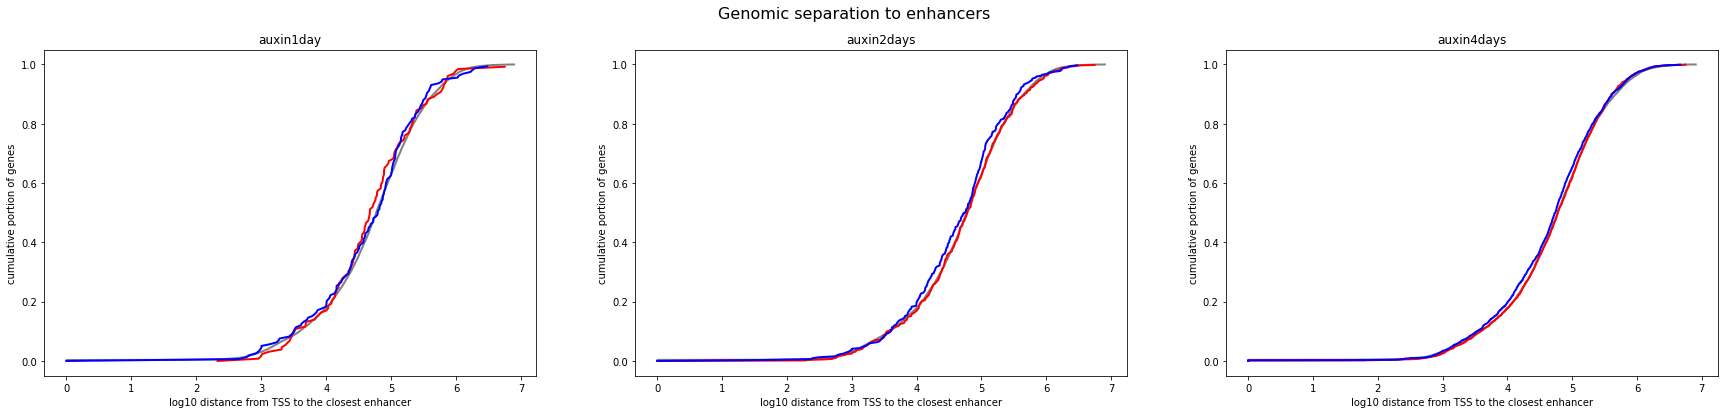

In [20]:
# Only plotting the change/distance to coordinates for DE results that are 1. AID-tagged and 2. have had some auxin treatment
only_treatment_results = [x for x in list(basic_deseq_results.keys()) if 'CTCF_AID_auxin' in x] 

# Generating a subplot for each of the conditions
num_plots = len(only_treatment_results)
fig, axs = plt.subplots(1, num_plots, figsize=[num_plots*10, 6])
fig.suptitle("Genomic separation to enhancers", fontsize=16)

# plot log10 distance between TSS and closest enhancers, color-coded by up-regulated/down-regulated or non-regulated genes
for condition, ax in zip(only_treatment_results, axs.ravel()):
    
    # adding TSS coordinates for the DEseq results
    tss_deseq_res = basic_deseq_results[condition].merge(tss_df.drop_duplicates(['gene_id']),
                                                         how='inner',
                                                         on='gene_id')
    
    # Using bioframe to find distance between TSS and closest enhancer
    closest_intervals = bf.closest(tss_deseq_res, enhancer_coords, suffixes=('_de_tss','_enhancer'))
    tss_deseq_res['distance_to_enhancer'] = closest_intervals['distance']
    
    # Filtering by significant (padj<0.5) --> separate by up-regulated and down-regulated
    up_ix = np.where((tss_deseq_res['padj'] < 0.05) & (tss_deseq_res['log2FoldChange'] > 0))
    down_ix = np.where((tss_deseq_res['padj'] < 0.05) & (tss_deseq_res['log2FoldChange'] < 0))
    nonsig_ix = np.where(tss_deseq_res['padj'] >= 0.05)
    
    # Getting the sets of genes
    up_reg_genes = tss_deseq_res.iloc[up_ix]
    down_reg_genes = tss_deseq_res.iloc[down_ix]
    nonsig_genes = tss_deseq_res.iloc[nonsig_ix]
    
    ## Bug/error investigating --> 'RuntimeWarning: divide by zero encountered in log10'
    print("Any distances between TSS and enhancer = 0?")
    print("Up-regulated genes: " + str(len(up_reg_genes[up_reg_genes['distance_to_enhancer'] == 0])))
    print("Down-regulated genes: " + str(len(down_reg_genes[down_reg_genes['distance_to_enhancer'] == 0])))
    print("Non-regulated genes: " + str(len(nonsig_genes[nonsig_genes['distance_to_enhancer'] == 0])))
    
    # Changing these values to = 1 
    tss_deseq_res.loc[tss_deseq_res['distance_to_enhancer'] == 0, 'distance_to_enhancer'] = 1
    
    # generate y axis: cumulative proportion of genes
    cum_all = np.arange(0, len(tss_deseq_res.iloc[nonsig_ix]), 1)
    cum_all = cum_all/ len(tss_deseq_res.iloc[nonsig_ix])

    # plotting 
    ax.plot(np.log10(tss_deseq_res.iloc[nonsig_ix]['distance_to_enhancer'].sort_values()), 
                cum_all, 
                color='grey',
                label='Non-regulated',
                linewidth=2)


    # generate y axis: cumulative proportion of genes
    cum_up = np.arange(0, len(tss_deseq_res.iloc[up_ix]), 1)
    cum_up = cum_up/ len(tss_deseq_res.iloc[up_ix])

    ax.plot(np.log10(tss_deseq_res.iloc[up_ix]['distance_to_enhancer'].sort_values()), 
                cum_up, 
                color='red', 
                label='Up-regulated',
                linewidth=2)

    # generate y axis: cumulative proportion of genes
    cum_down = np.arange(0, len(tss_deseq_res.iloc[down_ix]), 1)
    cum_down = cum_down/ len(tss_deseq_res.iloc[down_ix])

    ax.plot(np.log10(tss_deseq_res.iloc[down_ix]['distance_to_enhancer'].sort_values()),
                cum_down,
                color='blue',
                label='Down-regulated',
                linewidth=2)
    
    ax.set_title(condition.replace("CTCF_AID_", ""))
    ax.set_xlabel("log10 distance from TSS to the closest enhancer")
    ax.set_ylabel("cumulative portion of genes")
    
    # Printing the raw number of significantly DE genes, for reference  
    print("=================")
    print("For condition {}, there are {} DE genes out of {} total (that have a mappable TSS)".format(condition, 
                                                                                                      len(tss_deseq_res) - len(nonsig_genes), 
                                                                                                      len(tss_deseq_res)))
    print("Number of up-regulated genes: {}".format(len(up_reg_genes)))
    print("Number of down-regulated genes: {}".format(len(down_reg_genes)))
    print()
    
plt.show()

## Variation 2: DEG's from Nora 2017 supplementary table

## Formatting and labelling supplementary table of DE results

In [22]:
fpkm.head(5)

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,2days_washoff_2days.1,WT_untreated_mean_FPKM,WT_2days_mean_FPKM,WT_4days_mean_FPKM
0,0610005C13Rik,chr7:52823164-52845080,0.784511,0.804255,1.040841,2.176798,1.209881,no,no,no,no,0.531110,0.539697,0.414068
1,0610007P14Rik,chr12:87156404-87165495,71.716133,74.856200,63.412767,59.250033,67.995733,no,no,no,no,57.020867,49.716167,57.023633
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,no,58.497000,46.990267,58.072767
3,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,no,1.180704,1.977405,0.825640
4,0610009O20Rik,chr18:38398058-38422283,17.565900,20.652933,20.476800,20.633733,18.857300,no,no,no,no,18.864133,18.413433,18.779333


### Task 1: matching tracking_id (MGI ids http://www.informatics.jax.org/) to ensembl ids

- Attempt using MRK_ENSEMBL.rpt downloaded from MGI website http://www.informatics.jax.org/downloads/reports/index.html
  - issues: no versioning associated?

In [23]:
# mold fpkm data to be more like the above

In [24]:
mgi_ensembl = pd.read_csv("/project/fudenber_735/genomes/mm9/ensembl/ensembl_relational_downloads/MRK_ENSEMBL.rpt", sep='\t', header=None)

In [25]:
print(mgi_ensembl.shape[0])
mgi_ensembl.head(3)

55341


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,MGI:1915733,1110002O04Rik,RIKEN cDNA 1110002O04 gene,-1.00,1,ENSMUSG00000102531,ENSMUST00000194261,NaN,lncRNA gene,35918926,35920200,+,ncRNA|lncRNA
1,MGI:1919275,1600012P17Rik,RIKEN cDNA 1600012P17 gene,68.49,1,ENSMUSG00000047661,ENSMUST00000062159 ENSMUST00000162474,NaN,lncRNA gene,158795271,158808032,-,lncRNA|ncRNA
2,MGI:1914753,1700001G17Rik,RIKEN cDNA 1700001G17 gene,12.78,1,ENSMUSG00000103746,NaN,NaN,lncRNA gene,33708905,33709793,+,TEC|ncRNA


In [26]:
# add column names
mgi_ensembl = mgi_ensembl.rename(columns={0 : 'mgi_id',
                            1 : 'mgi_gene',
                            2 : 'description',
                            3 : 'not_sure',
                            4 : 'chrom',
                            5 : 'ensembl_gene_id',
                            6 : 'ensembl_transcript_ids',
                            7 : 'ensembl_protein_id',
                            8 : 'biotype',
                            9 : 'start',
                            10 : 'end',
                            11 : 'strand',
                            12 : 'possible_biotypes'})

In [27]:
# first, mapping to deseq results to see compatibility/completeness of the two sets
print("number of unique id's in DEseq results (from kallisto mapping): " + str(basic_deseq_results['CTCF_AID_auxin1day']['gene_id'].nunique()))

basic_deseq_results['CTCF_AID_auxin1day'].merge(mgi_ensembl, how='left', left_on='gene_id', right_on='ensembl_gene_id')

number of unique id's in DEseq results (from kallisto mapping): 26520


,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,mgi_id,mgi_gene,description,not_sure,chrom,ensembl_gene_id,ensembl_transcript_ids,ensembl_protein_id,biotype,start,end,strand,possible_biotypes
0,ENSMUSG00000000001,4942.457855,-0.033551,0.236434,-0.141905,8.871554e-01,9.998054e-01,MGI:95773,Gnai3,guanine nucleotide binding protein (G protein)...,46.83,3,ENSMUSG00000000001,ENSMUST00000000001,ENSMUSP00000000001,protein coding gene,108014596.0,108053462.0,-,protein-coding|protein_coding
1,ENSMUSG00000000003,0.000000,NaN,NaN,NaN,NaN,NaN,MGI:1860484,Pbsn,probasin,38.32,X,ENSMUSG00000000003,ENSMUST00000000003 ENSMUST00000114041,ENSMUSP00000000003 ENSMUSP00000109675,protein coding gene,76881504.0,76897106.0,-,protein_coding|protein-coding
2,ENSMUSG00000000028,2278.335221,-0.091383,0.163252,-0.559764,5.756404e-01,9.998054e-01,MGI:1338073,Cdc45,cell division cycle 45,11.63,16,ENSMUSG00000000028,ENSMUST00000231819 ENSMUST00000096990 ENSMUST0...,ENSMUSP00000094753 ENSMUSP00000111248 ENSMUSP0...,protein coding gene,18599197.0,18630737.0,-,protein_coding|protein-coding
3,ENSMUSG00000000037,398.325060,2.463827,0.236823,10.403647,2.386216e-25,4.369956e-22,MGI:1340042,Scml2,Scm polycomb group protein like 2,73.95,X,ENSMUSG00000000037,ENSMUST00000238603 ENSMUST00000077375 ENSMUST0...,ENSMUSP00000076593 ENSMUSP00000019101 ENSMUSP0...,protein coding gene,159865521.0,160041209.0,+,protein-coding|protein_coding
4,ENSMUSG00000000049,0.000000,NaN,NaN,NaN,NaN,NaN,MGI:88058,Apoh,apolipoprotein H,71.80,11,ENSMUSG00000000049,ENSMUST00000152958 ENSMUST00000146050 ENSMUST0...,ENSMUSP00000123486 ENSMUSP00000114214 ENSMUSP0...,protein coding gene,108286123.0,108305222.0,+,protein_coding|protein-coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26516,ENSMUSG00000084412,0.000000,NaN,NaN,NaN,NaN,NaN,MGI:3651841,Gm12044,predicted gene 12044,13.89,11,ENSMUSG00000084412,ENSMUST00000120335,NaN,pseudogene,21401142.0,21401354.0,-,processed_pseudogene
26517,ENSMUSG00000084413,9.829391,1.454489,1.157044,1.257073,2.087272e-01,9.998054e-01,MGI:3651377,Gm12017,predicted gene 12017,10.45,11,ENSMUSG00000084413,ENSMUST00000122453,NaN,pseudogene,17923788.0,17924790.0,-,processed_pseudogene|pseudo
26518,ENSMUSG00000084414,0.060269,-0.698860,4.055402,-0.172328,8.631796e-01,NaN,MGI:3649599,Gm11270,predicted gene 11270,7.73,13,ENSMUSG00000084414,ENSMUST00000117685,NaN,pseudogene,21480418.0,21480888.0,-,pseudo|processed_pseudogene
26519,ENSMUSG00000084415,0.000000,NaN,NaN,NaN,NaN,NaN,MGI:3649425,Gm12837,predicted gene 12837,52.99,4,ENSMUSG00000084415,ENSMUST00000120131,NaN,pseudogene,115273279.0,115273651.0,-,pseudo|processed_pseudogene


In [28]:
result_df = basic_deseq_results['CTCF_AID_auxin1day'].copy()

# Let's add this label to our results dataset
result_df['mgi_gene'] = result_df.merge(mgi_ensembl, how='left', left_on='gene_id', right_on='ensembl_gene_id')['mgi_gene']

# count any that didn't have an mgi_gene match
result_df['mgi_gene'].isna().sum()

2537

In [29]:
result_df[result_df['mgi_gene'].isna()]

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,mgi_gene
59,ENSMUSG00000000325,1176.624728,0.139254,0.489379,0.284553,0.775987,0.999805,NaN
117,ENSMUSG00000000702,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
240,ENSMUSG00000001379,627.512892,-0.133893,0.172369,-0.776780,0.437289,0.999805,NaN
406,ENSMUSG00000002290,12.458554,0.148792,0.751600,0.197967,0.843071,0.999805,NaN
539,ENSMUSG00000003178,468.462225,-0.240071,0.199192,-1.205225,0.228117,0.999805,NaN
...,...,...,...,...,...,...,...,...
26502,ENSMUSG00000084399,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
26506,ENSMUSG00000084403,2.354672,-0.070210,1.486532,-0.047231,0.962329,NaN,NaN
26510,ENSMUSG00000084407,0.266680,1.835794,4.037416,0.454695,0.649329,NaN,NaN
26513,ENSMUSG00000084410,5.151212,1.207003,1.291019,0.934923,0.349828,0.999805,NaN


### We'll see about the reverse (mapping mgi_id --> ensembl)

In [30]:
fpkm['ensembl_gene_id'] = fpkm.merge(mgi_ensembl, how='left', left_on='tracking_id', right_on='mgi_gene')['ensembl_gene_id']
fpkm.head(10)

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,2days_washoff_2days.1,WT_untreated_mean_FPKM,WT_2days_mean_FPKM,WT_4days_mean_FPKM,ensembl_gene_id
0,0610005C13Rik,chr7:52823164-52845080,0.784511,0.804255,1.040841,2.176798,1.209881,no,no,no,no,0.531110,0.539697,0.414068,ENSMUSG00000109644
1,0610007P14Rik,chr12:87156404-87165495,71.716133,74.856200,63.412767,59.250033,67.995733,no,no,no,no,57.020867,49.716167,57.023633,NaN
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,no,58.497000,46.990267,58.072767,ENSMUSG00000007777
3,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,no,1.180704,1.977405,0.825640,ENSMUSG00000043644
4,0610009O20Rik,chr18:38398058-38422283,17.565900,20.652933,20.476800,20.633733,18.857300,no,no,no,no,18.864133,18.413433,18.779333,NaN
5,0610010B08Rik,chr2:174952492-175261278,0.057933,0.051192,0.080296,0.091421,0.090390,no,no,no,no,0.071852,0.105181,0.096969,NaN
6,0610010F05Rik,chr11:23473775-23533631,4.500230,4.654253,3.784197,3.342397,4.257007,no,no,no,no,4.556360,3.955583,4.441780,NaN
7,0610010K14Rik,chr11:70048705-70051416,115.794100,134.728000,124.419633,109.027433,95.227500,no,no,no,no,104.590300,129.307667,99.449367,ENSMUSG00000020831
8,0610011F06Rik,chr17:26012444-26014108,12.449400,12.249967,11.492490,12.151867,11.099847,no,no,no,no,10.334770,14.981610,11.079557,NaN
9,0610012G03Rik,chr16:31947136-31948607,34.492833,40.396067,36.419533,30.946500,30.611233,no,no,no,no,26.746667,35.935333,23.776233,ENSMUSG00000107002


In [31]:
# how many are missing
missing = fpkm['ensembl_gene_id'].isna().sum()
tot = fpkm.shape[0]

print("Out of {} genes labeled by mgi gene name in Nora results table, {} are missing a corresponding ensembl id, {}%.".format(tot, 
                                                                                                                               missing,
                                                                                                                               missing/tot))

Out of 24315 genes labeled by mgi gene name in Nora results table, 1562 are missing a corresponding ensembl id, 0.06424018095825622%.


For the purposes of checking/verifying consistency, we'll just toss the un-matched ones. If things look really weird, find a better reference?

In [32]:
fpkm = fpkm.merge(tss_df.drop_duplicates(['gene_id']), how='inner', left_on='ensembl_gene_id', right_on='gene_id', suffixes=('_data', '_tss')) 

new_len = fpkm.shape[0]

print("Out of {} genes in results table, {} had a corresponding TSS (so {} were dropped)".format(tot, new_len, tot-new_len))

Out of 24315 genes in results table, 20188 had a corresponding TSS (so 4127 were dropped)


In [33]:
fpkm.head(5)

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,chrom,source,feature,start,end,score,strand,frame,transcript_id,gene_id
0,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,chr11,gffutils_derived,transcript,51502156,51502156,NaN,-,0,ENSMUST00000007921,ENSMUSG00000007777
1,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,...,chr11,gffutils_derived,transcript,120209991,120209991,NaN,+,0,ENSMUST00000143813,ENSMUSG00000043644
2,0610010K14Rik,chr11:70048705-70051416,115.794100,134.728000,124.419633,109.027433,95.227500,no,no,no,...,chr11,gffutils_derived,transcript,70051417,70051417,NaN,-,0,ENSMUST00000021180,ENSMUSG00000020831
3,0610030E20Rik,chr6:72297310-72303154,3.961530,4.223233,4.699287,5.407897,4.271537,no,no,no,...,chr6,gffutils_derived,transcript,72297310,72297310,NaN,+,0,ENSMUST00000077783,ENSMUSG00000058706
4,0610039K10Rik,chr2:163449008-163471536,0.337451,0.253110,0.320109,0.318655,0.178876,no,no,no,...,chr2,gffutils_derived,transcript,163470585,163470585,NaN,+,0,ENSMUST00000076667,ENSMUSG00000058812


In [34]:
# Get distance between TSSes and the closest enhancer
closest_intervals_nora = bf.closest(fpkm, enhancer_coords, suffixes=('_de_tss','_enhancer'))
fpkm['distance_to_enhancer'] = closest_intervals_nora['distance']

In [35]:
fpkm

,tracking_id,locus,CTCF-AID_untreated_mean_FPKM,CTCF-AID_1day_mean_FPKM,CTCF-AID_2days_mean_FPKM,CTCF-AID_4days_mean_FPKM,CTCF-AID_washoff_mean_FPKM,1day.1,2days.1,4days.1,...,source,feature,start,end,score,strand,frame,transcript_id,gene_id,distance_to_enhancer
0,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,gffutils_derived,transcript,51502156,51502156,NaN,-,0,ENSMUST00000007921,ENSMUSG00000007777,27016
1,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,...,gffutils_derived,transcript,120209991,120209991,NaN,+,0,ENSMUST00000143813,ENSMUSG00000043644,23057
2,0610010K14Rik,chr11:70048705-70051416,115.794100,134.728000,124.419633,109.027433,95.227500,no,no,no,...,gffutils_derived,transcript,70051417,70051417,NaN,-,0,ENSMUST00000021180,ENSMUSG00000020831,22539
3,0610030E20Rik,chr6:72297310-72303154,3.961530,4.223233,4.699287,5.407897,4.271537,no,no,no,...,gffutils_derived,transcript,72297310,72297310,NaN,+,0,ENSMUST00000077783,ENSMUSG00000058706,312
4,0610039K10Rik,chr2:163449008-163471536,0.337451,0.253110,0.320109,0.318655,0.178876,no,no,no,...,gffutils_derived,transcript,163470585,163470585,NaN,+,0,ENSMUST00000076667,ENSMUSG00000058812,19451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20183,Zyx,chr6:42299826-42330557,8.531693,8.734813,11.727350,24.111000,11.359220,no,no,yes,...,gffutils_derived,transcript,23737822,23737822,NaN,+,0,ENSMUST00000095595,ENSMUSG00000023902,1596846
20184,Zzef1,chr11:72609727-72740622,2.597283,2.411157,2.507930,3.121180,2.856007,no,no,no,...,gffutils_derived,transcript,21454695,21454695,NaN,+,0,ENSMUST00000053293,ENSMUSG00000036721,955775
20185,Zzz3,chr3:152058966-152344396,9.986867,8.012557,7.069317,8.471867,10.256167,no,no,no,...,gffutils_derived,transcript,13361008,13361008,NaN,-,0,ENSMUST00000046245,ENSMUSG00000070822,1169839
20186,a,chr2:154839305-154876748,0.087051,0.167859,0.370351,0.402713,0.090154,no,no,no,...,gffutils_derived,transcript,88006993,88006993,NaN,+,0,ENSMUST00000044115,ENSMUSG00000038797,1618148


In [36]:
# todo:

# assign TSSes to fpkm
# get distance between these TSSes and the enhancer data
# for each day condition:
    # filter for 'sig' by 1day.1, 2days.1, 4days.1
    # graph the distances, sorted in each of these three groups

In [37]:
up = fpkm.iloc[np.where((fpkm['1day.1'] == 'yes') & ((fpkm['CTCF-AID_untreated_mean_FPKM'] - fpkm['CTCF-AID_1day_mean_FPKM']) < 0))]
down = fpkm.iloc[np.where((fpkm['1day.1'] == 'yes') & ((fpkm['CTCF-AID_untreated_mean_FPKM'] - fpkm['CTCF-AID_1day_mean_FPKM']) > 0))]
non = fpkm.iloc[np.where(fpkm['1day.1'] == 'no')]

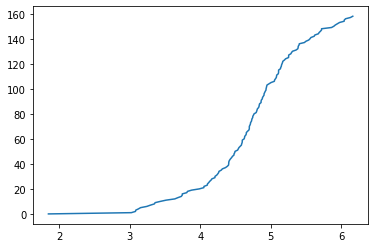

In [38]:
plt.plot(np.log10(up['distance_to_enhancer'].sort_values()), np.arange(0, len(up), 1))

In [39]:
# Changing these values to = 1 
fpkm.loc[fpkm['distance_to_enhancer'] == 0, 'distance_to_enhancer'] = 1

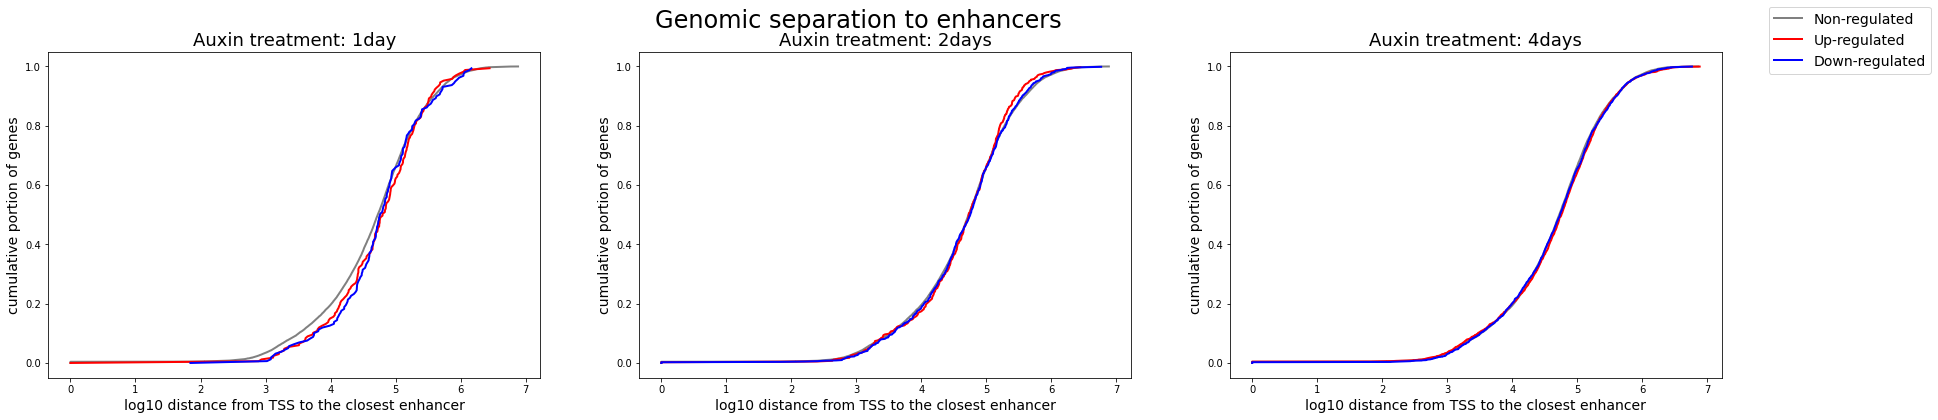

In [46]:
days = ['1day', '2days', '4days']

# Generating a subplot for each of the conditions
num_plots = len(days)
fig, axs = plt.subplots(1, num_plots, figsize=[num_plots*10, 6])
fig.suptitle("Genomic separation to enhancers", fontsize=24)

for day, ax in zip(days, axs.ravel()):
    
    up_reg = fpkm.iloc[np.where((fpkm[day + '.1'] == 'yes') & ((fpkm['CTCF-AID_untreated_mean_FPKM'] - fpkm['CTCF-AID_' + day + '_mean_FPKM']) > 0))]
    down_reg = fpkm.iloc[np.where((fpkm[day + '.1'] == 'yes') & ((fpkm['CTCF-AID_untreated_mean_FPKM'] - fpkm['CTCF-AID_' + day + '_mean_FPKM']) < 0))]
    non_reg = fpkm.iloc[np.where(fpkm[day + '.1'] == 'no')]
    
    # generate y axis: cumulative proportion of genes
    cum_all = np.arange(0, len(non_reg), 1)
    cum_all = cum_all/ len(non_reg)

    # plotting 
    ax.plot(np.log10(non_reg['distance_to_enhancer'].sort_values()), 
                cum_all, 
                color='grey',
                label='Non-regulated',
                linewidth=2)


    # generate y axis: cumulative proportion of genes
    cum_up = np.arange(0, len(up_reg), 1)
    cum_up = cum_up/ len(up_reg)

    ax.plot(np.log10(up_reg['distance_to_enhancer'].sort_values()), 
                cum_up, 
                color='red', 
                label='Up-regulated',
                linewidth=2)

    # generate y axis: cumulative proportion of genes
    cum_down = np.arange(0, len(down_reg), 1)
    cum_down = cum_down/ len(down_reg)

    ax.plot(np.log10(down_reg['distance_to_enhancer'].sort_values()),
                cum_down,
                color='blue',
                label='Down-regulated',
                linewidth=2)
    
    ax.set_title("Auxin treatment: " + day, fontsize=18)
    ax.set_xlabel("log10 distance from TSS to the closest enhancer", fontsize=14)
    ax.set_ylabel("cumulative portion of genes", fontsize=14)
    
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=14)
plt.show()

# Scratch work / misc

### Below is work for generating first graph, was put into the for loop, above, but keeping in case process is easier to decipher in steps below

In [77]:
closest_intervals = bf.closest(tss_deseq_res, enhancer_coords, suffixes=('_de_tss','_enhancer'))
display(closest_intervals)
len(closest_intervals)

,gene_id_de_tss,baseMean_de_tss,log2FoldChange_de_tss,lfcSE_de_tss,stat_de_tss,pvalue_de_tss,padj_de_tss,chrom_de_tss,source_de_tss,feature_de_tss,...,end_de_tss,score_de_tss,strand_de_tss,frame_de_tss,transcript_id_de_tss,chrom_enhancer,start_enhancer,end_enhancer,value_enhancer,distance
0,ENSMUSG00000000544,2291.751812,-0.178754,0.255600,-0.699352,0.484332,0.999805,chr1,gffutils_derived,transcript,...,168060547,NaN,+,0,ENSMUST00000027847,chr1,168055001,168056000,"0,9624",4547
1,ENSMUSG00000000817,1.790351,-0.737808,1.908559,-0.386579,0.699068,NaN,chr1,gffutils_derived,transcript,...,163718627,NaN,-,0,ENSMUST00000000834,chr1,163849001,163850000,"0,7004",130374
2,ENSMUSG00000001138,640.593647,-0.257097,0.262880,-0.978004,0.328073,0.999805,chr1,gffutils_derived,transcript,...,36568711,NaN,+,0,ENSMUST00000001166,chr1,36587001,36588000,"0,4348",18290
3,ENSMUSG00000001143,115.038360,-0.475708,0.728265,-0.653207,0.513623,0.999805,chr1,gffutils_derived,transcript,...,36502117,NaN,-,0,ENSMUST00000001171,chr1,36587001,36588000,"0,4348",84884
4,ENSMUSG00000001305,4027.317920,-0.101227,0.297815,-0.339898,0.733933,0.999805,chr1,gffutils_derived,transcript,...,188573238,NaN,-,0,ENSMUST00000001339,chr1,188434001,188435000,"0,3842",138238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25780,ENSMUSG00000069044,6.949773,1.272515,1.052337,1.209228,0.226575,0.999805,chrY,gffutils_derived,transcript,...,796226,NaN,-,0,ENSMUST00000091188,chrY,1752001,1753000,"0,473",955775
25781,ENSMUSG00000069045,160.679467,-0.292968,0.501614,-0.584051,0.559186,0.999805,chrY,gffutils_derived,transcript,...,623057,NaN,-,0,ENSMUST00000091190,chrY,1752001,1753000,"0,473",1128944
25782,ENSMUSG00000069049,937.139720,0.148641,0.174857,0.850074,0.395284,0.999805,chrY,gffutils_derived,transcript,...,346985,NaN,+,0,ENSMUST00000091197,chrY,1752001,1753000,"0,473",1405016
25783,ENSMUSG00000069053,84.431660,-0.005782,0.369600,-0.015643,0.987519,0.999805,chrY,gffutils_derived,transcript,...,155155,NaN,+,0,ENSMUST00000115894,chrY,1752001,1753000,"0,473",1596846


25785

In [78]:
tss_deseq_res['distance_to_enhancer'] = closest_intervals['distance']

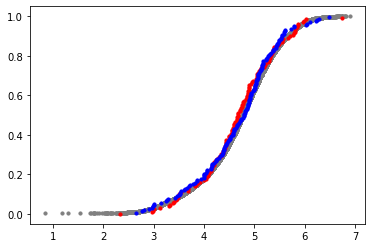

In [101]:
# generate y axis: cumulative proportion of genes
cum_all = np.arange(0, len(tss_deseq_res.iloc[nonsig_ix]), 1)
cum_all = cum_all/ len(tss_deseq_res.iloc[nonsig_ix])

plt.scatter(np.log10(tss_deseq_res.iloc[nonsig_ix]['distance_to_enhancer'].sort_values()), 
            cum_all, 
            color='grey',
            s=10,
            label='Non-regulated')


# generate y axis: cumulative proportion of genes
cum_up = np.arange(0, len(tss_deseq_res.iloc[up_ix]), 1)
cum_up = cum_up/ len(tss_deseq_res.iloc[up_ix])

plt.scatter(np.log10(tss_deseq_res.iloc[up_ix]['distance_to_enhancer'].sort_values()), 
            cum_up, 
            color='red', 
            s=10,
            label='Up-regulated')

# generate y axis: cumulative proportion of genes
cum_down = np.arange(0, len(tss_deseq_res.iloc[down_ix]), 1)
cum_down = cum_down/ len(tss_deseq_res.iloc[down_ix])

plt.scatter(np.log10(tss_deseq_res.iloc[down_ix]['distance_to_enhancer'].sort_values()),
            cum_down,
            color='blue',
            s=10,
            label='Down-regulated')
            